## Experiment Overview

In this experiment, we will use a character-based Recurrent Neural Network (RNN) to generate Shakespeare-like text based on the Shakespeare dataset from the blog post *The Unreasonable Effectiveness of Recurrent Neural Networks*.

For this experiment, we will use TensorFlow v2 with its Keras API.

## Import dependencies

This code is used to select TensorFlow version 2.x in a Colab environment. The command `%tensorflow_version 2.x` is specifically relevant for Google Colab notebooks, allowing users to switch to the desired TensorFlow version if the default version is not 2.x.

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

TensorFlow 2.x selected.


The following code cell imports several essential libraries for the experiment, including TensorFlow, Matplotlib, NumPy, and others for system-related tasks. It also prints out the versions of Python, TensorFlow, and Keras currently being used, which can help ensure compatibility and track the environment setup.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Download the dataset

In [3]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1122304/1115394 [==============================] - 0s 0us/step
/content/tmp/datasets/shakespeare.txt


## Analyze the dataset

In [4]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [11]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [12]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [16]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size.
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [20]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [21]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[39 58 59 ... 57 58 53]
 [47 52  1 ...  1 63 53]
 [53 61  1 ... 46 57  6]
 ...
 [ 1 57 43 ... 52 42  8]
 [58 46 43 ... 43  1 58]
 [56 43 47 ... 53 59  1]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[58 59 56 ... 58 53 41]
 [52  1 63 ... 63 53 59]
 [61  1 50 ... 57  6  1]
 ...
 [57 43 43 ... 42  8  0]
 [46 43 43 ...  1 58 53]
 [43 47 45 ... 59  1 61]], shape=(64, 100), dtype=int64)


## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [ ]:
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))

tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[9 0 2 1 4 6 8 8]
 [3 7 9 1 0 4 8 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.01348125  0.04649678  0.03382711  0.03225223  0.00077888]
  [ 0.01548834  0.02294052 -0.03144439 -0.02458044 -0.01775809]
  [-0.01713194  0.02779663  0.02824989 -0.01959893 -0.01335952]
  [-0.00085108 -0.04381631  0.04934248  0.01773458 -0.0059096 ]
  [-0.04360831  0.02180418  0.04860454 -0.04669809  0.0012654 ]
  [-0.04296128  0.00703833 -0.01924504 -0.03515936 -0.00462629]
  [ 0.03757649  0.01776652  0.0135636  -0.00759625  0.01923021]
  [ 0.03757649  0.01776652  0.0135636  -0.00759625  0.01923021]]

 [[-0.00344205 -0.04512044 -0.04339879 -0.04655287  0.04151651]
  [-0.01463156 -0.04065967 -0.03041167 -0.03633127 -0.04055873]
  [-0.01348125  0.04649678  0.03382711  0.03225223  0.00077888]
  [-0.00085108 -0.04381631  0.04934248  0.01773458 -0.0059096 ]
  [ 0.01548834  0.02294052 -0.03144439 -0.02458044 -0.01775809]
  [-0.04360831  0.02180418 

In [0]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


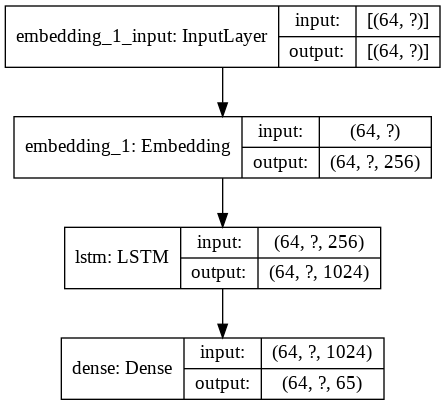

In [28]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

## Try the model

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [30]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-5.5658985e-03 -5.6167855e-03  2.3333444e-03 -5.4010577e-03
 -1.2658490e-03 -2.0685978e-03 -1.7119508e-03 -1.9059415e-03
 -1.8099162e-03  1.8549486e-03 -6.1538210e-03  2.1649192e-03
  5.9574037e-03  3.1515316e-03 -3.3867492e-03  6.0820174e-03
  2.0375988e-03  1.1445739e-03  1.3204901e-03 -2.5559508e-03
 -6.7244383e-04  2.0627938e-03 -5.1490301e-03  5.0887186e-03
 -2.1955089e-03 -5.3793588e-03  3.5228319e-03 -1.3459967e-03
  1.5698730e-03 -3.6733383e-03 -2.6844436e-04  1.2893401e-03
 -2.9499468e-03 -2.0524827e-03  4.9254433e-03 -1.4868007e-03
 -3.2468680e-03 -3.1228375e-03  1.4175450e-03  2.6028175e-03
 -1.9702244e-04 -1.5901095e-04 -5.2650859e-05 -2.0922027e-03
 -1.1370353e-03 -1.3396480e-03  2.7639134e-04  2.6140050e-03
  3.0784088e-04 -7.5585191e-04  2.4966525e-03  1.0233605e-03
  1.4258339e-03 -1.6010429e-04  5.1720534e-03  9.4948718e-03
 -4.6309843e-03  5.5265515e-03 -1.2462666e-04 -1.3864412e-03
 -2.6601439e-03  

In [ ]:
tmp_logits = [
  [-0.95, 0, 0.95],
];

tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 1 2]], shape=(1, 5), dtype=int64)


In [32]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [33]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [34]:
sampled_indices

array([62, 61, 40, 20,  4, 44, 17, 43, 28, 18, 50, 48,  0, 11, 58, 17, 41,
       22, 62, 46, 12, 24, 25, 54, 10,  6, 18,  5,  4, 23, 55, 51, 38,  9,
       50, 42, 42,  9, 49,  4, 48, 54, 59,  4, 30,  7, 20,  4, 53, 27, 21,
        5, 16, 27, 25, 47, 21,  7, 24, 25, 46, 21,  6, 56,  1, 21, 24, 28,
       55,  8, 23,  0, 45, 29,  4, 29,  5, 49, 25, 45,  3,  4, 22, 11, 13,
       30, 43,  0, 62,  0, 48, 29, 33, 58, 46, 51, 12, 59, 55, 62])

In [35]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'is service.\n\nBAPTISTA:\nA thousand thanks, Signior Gremio.\nWelcome, good Cambio.\nBut, gentle sir, met'

Next char prediction:
 "xwbH&fEePFlj\n;tEcJxh?LMp:,F'&KqmZ3ldd3k&jpu&R-H&oOI'DOMiI-LMhI,r ILPq.K\ngQ&Q'kMg$&J;ARe\nx\njQUthm?uqx"


In [36]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 47 ('i')
  next predicted: 1 ('x')
Prediction  1
  input: 57 ('s')
  next predicted: 1 ('w')
Prediction  2
  input: 1 (' ')
  next predicted: 1 ('b')
Prediction  3
  input: 57 ('s')
  next predicted: 1 ('H')
Prediction  4
  input: 43 ('e')
  next predicted: 1 ('&')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.17424


In [0]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [0]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [0]:
EPOCHS=40

In [41]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Train for 172 steps
Epoch 1/40
172/172 [==============================] - 31s 179ms/step - loss: 2.5607
Epoch 2/40
172/172 [==============================] - 29s 171ms/step - loss: 1.8654
Epoch 3/40
172/172 [==============================] - 30s 172ms/step - loss: 1.6191
Epoch 4/40
172/172 [==============================] - 30s 172ms/step - loss: 1.4893
Epoch 5/40
172/172 [==============================] - 30s 172ms/step - loss: 1.4108
Epoch 6/40
172/172 [==============================] - 30s 172ms/step - loss: 1.3550
Epoch 7/40
172/172 [==============================] - 30s 172ms/step - loss: 1.3101
Epoch 8/40
172/172 [==============================] - 30s 172ms/step - loss: 1.2705
Epoch 9/40
172/172 [==============================] - 30s 173ms/step - loss: 1.2335
Epoch 10/40
172/172 [==============================] - 30s 173ms/step - loss: 1.1980
Epoch 11/40
172/172 [==============================] - 29s 171ms/step - loss: 1.1610
Epoch 12/40
172/172 [==============================] -

In [0]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

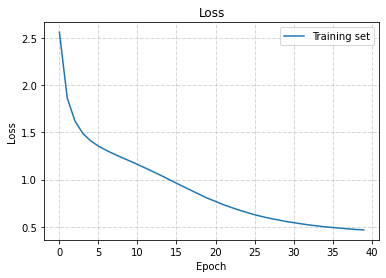

In [43]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [44]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_40'

In [0]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

In [0]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [48]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: God do not burden me.

GREMIO:
I want the king that murders writ upon your tongue
And born too supplict, but thanks
We should to him and nothing can I never my
brothers forbeard our words:
Confess which have wine, and provide thee
And see how did bestride our nobising duke,
Whose souls more pleased, that men are worst challenge into a farmet together
Let hate not so, for these own with him.

Tailors:
But now the blood of two,
You and your accused find your wars.

MENENIUS:
Part not chastisement; hidest me well arm'd
With eterpity of the mon poor house.

Third Servant:
When you are gentlemen, some interr'd
As is my goods, God says King Richard say,
As is the sin that she doth aim at you
As I could pick my daughter woful side!
Thou follow'st me in his life, against your husband's land:
My lawful king is dead! wis gone to ET:
Where is my woful? Was never man so bath
Lord Her further.

BRUTUS:
Let me prepare from fair, nor ambition
That spucish him our absence, like a grave is no mo

In [49]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: hexen his virginallike.

BRUTUS:
For thyself
Look, sirr; let not this innocent mine friends
And hateful dogs as appeared, for it exced
Exelling clouds with gentle knterpleaking:
Their liberal dogs not his;
For Yorkome help, ho! ay, I trow:
it will we meet us king E:
Needs friends, father, in that mad bessisking in
Whom I might thrive is rich'd die by thee?

CORIOLANUS:
Brak how, gnow roaring with Sicils
Up Jusul's dee Signior Katharina,
And thyself shalt hear of that which the ear o' Lord:
You are the first gape on me at first,
Thou lovest me wash:
By heaven, I'll haughthere.
O, gentle marvantio; and beginn pluck'd
But the christs and Riciards a
LUUMEOfoke fray,
And yet whick, in my doesder differences be runed by the king,
Who in his monthry glorious regeal death.
O, that she smooth thy cause?
Was e turn be so
to thine as thee won that Edward, king, widdwisk
Ere te goil: deserve not thy mother leave for reason
many an hourable fought, as they do,
If you should esear mon-judgmen

## Save the model

In [0]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')